In [84]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression, Ridge
import itertools
from tqdm.notebook import tqdm

In [25]:
def logistic_map(x0, r, K, n):
    # x(t+1) = r*(x(t) + 1/K * x(t))
    x0 = max(x0, 1e-3)
    x = np.zeros(n)
    if n > 0:
        x[0] = x0
    x_t = x0
    for i in range(1, n):
        x_t_1 = r * x_t * (1 - 1/K * x_t)
        x[i] = x_t_1
        x_t = x_t_1
    return x

$$
x_{t+1} = r x_t (1 - \frac{1}{K} x_t) = r x_t + \frac{r}{K} x_t^2 \Rightarrow \\
x_{t+1} / x_t = r (1 - \frac{1}{K} x_t) = r + \frac{r}{K} x_t 
$$

In [26]:
n = 30
r_true = 1.1
K_true = 4
r_K_ratio_true = r_true / K_true
# K_true = r_true / r_K_ratio_true

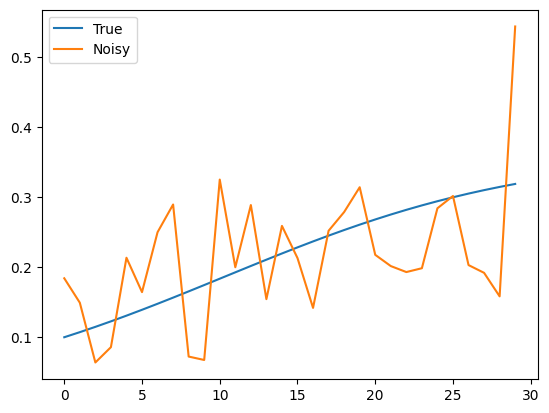

In [32]:
noise_scale = 0.1
x_true = logistic_map(0.1, r_true, K_true, n)
x = x_true * np.exp(np.random.normal(loc=0, scale=noise_scale, size=x_true.shape))
x = np.abs(x_true + np.random.normal(loc=0, scale=noise_scale, size=x_true.shape))

plt.plot(x_true, label='True')
plt.plot(x, label='Noisy')
plt.legend()
plt.show()

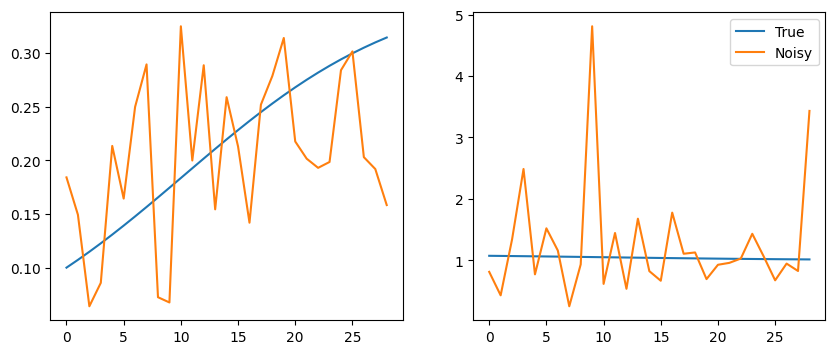

In [33]:
x_pct_true = x_true[1:] / x_true[:-1]
x_t_true = x_true[:-1]
x_t_1_true = x_true[1:]

x_pct = x[1:] / x[:-1]
x_t = x[:-1]
x_t_1 = x[1:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(x_t_true, label='True')
ax1.plot(x_t, label='Noisy')

ax2.plot(x_pct_true, label='True')
ax2.plot(x_pct, label='Noisy')
plt.legend()

In [34]:
def create_x_logistic(x0, r_true, K_true, n, noise_scale):
    x_true = logistic_map(x0, r_true, K_true, n)
    x = x_true * np.exp(np.random.normal(loc=0, scale=noise_scale, size=x_true.shape))
    return x

In [35]:
def expand_x_logistic(x, r, K, h_max):
    x_t_s = [x[:-1]]
    x_t_1_s = [x[1:]]
    w_s = [x[:-1]*0]
    h_min = 1
    
    for i in range(x.size-h_min-1):
        h = min(x.size - i, h_max)
        
        x_t = logistic_map(x[i], r, K, h)
        x_t_1 = x[(i+1):(i+h+1)]
        w = np.arange(h) + 1
        
        x_t_s.append(x_t)
        x_t_1_s.append(x_t_1)
        w_s.append(w)

    return np.concatenate(x_t_s), np.concatenate(x_t_1_s), np.concatenate(w_s)

In [100]:
def expand_x_logistic_pct(x, r, K, h_max):
    x_t_s = [x[:-1]]
    x_t_1_s = [x[1:]/x[:-1]]
    w_s = [x[:-1]*0]
    h_min = 1
    
    for i in range(x.size-h_min-1):
        h = min(x.size - i - 1, h_max)
        
        x_t = logistic_map(x[i], r, K, h)
        x_t_1 = x[(i+1):(i+h+1)] / x[(i):(i+h)]
        w = np.arange(h) + 1
        
        x_t_s.append(x_t)
        x_t_1_s.append(x_t_1)
        w_s.append(w)

    return np.concatenate(x_t_s), np.concatenate(x_t_1_s), np.concatenate(w_s)

In [37]:
def to_r_K(model_coef):
    r = model_coef[0]
    r_K_ratio = -model_coef[1]
    K = r / r_K_ratio
    return r, K

In [97]:
def logistic_EM(x, h, max_iter=100):
    x_t = x[:-1]
    x_t_1 = x[1:]
    
    # Init
    X = np.vstack([x_t, x_t*x_t]).T
    y = x_t_1
    # model = LinearRegression(fit_intercept=False).fit(X, y)
    model = Ridge(fit_intercept=False).fit(X, y)
    r, K = to_r_K(model.coef_)
    # print(f"r: {r}, K: {K}, score: {model.score(X, y)}")
    # Iter
    for i in range(max_iter):
        # x_t_synt, x_t_1_synt, w_synt = expand_x_logistic(x, r, K, h)
        # X_synt = np.vstack([x_t_synt, x_t_synt*x_t_synt]).T
        
        x_t_synt, x_t_1_synt, w_synt = expand_x_logistic_pct(x, r, K, h)
        X_synt = np.vstack([np.ones_like(x_t_synt), x_t_synt]).T
        y_synt = x_t_1_synt
        
        sample_weight = 1 / np.sqrt(1+w_synt)
        # sample_weight = np.exp(-.15*w_synt)
        # sample_weight = np.ones_like(sample_weight)
    
        # model = LinearRegression(fit_intercept=False).fit(X_synt, y_synt, sample_weight)
        model = Ridge(fit_intercept=False).fit(X_synt, y_synt, sample_weight)
        r, K = to_r_K(model.coef_)
        # if not i % 30:
        # print(f"r: {r}, K: {K}, score: {model.score(X, y)}, h: {h}, i: {i}")
              
    return r, K

In [98]:
def compute_grid_search_logistic(x0, r_true, K_true):
    # ns = np.arange(10, 301, 10)
    ns = [20, 50, 100, 200, 500]
    # hs = [0, 1, 2, 3, 5, 7, 10, 15, 20, 30]
    hs = [0, 3, 10, 30, 50, 100, 200]
    noise_scales = [.01, .02, .05]
    
    x_true = logistic_map(x0, r_true, K_true, max(ns))
    noise = np.random.normal(loc=0, scale=1, size=x_true.shape)
    
    results = []
    for n, h, noise_scale in itertools.product(ns, hs, noise_scales):
        # x = create_x_logistic(x0, r_true, K_true, n, noise_scale)
        x = (np.abs(x_true + (noise*noise_scale)) + 1e-4)[:n]
        # print('x:', x)
        
        r_hat, K_hat = logistic_EM(x, h, max_iter=4)
        
        result = {'x0_true': x0, 'r_true': r_true, 'K_true': K_true, 
                  'n': n, 'h': h, 'noise': noise_scale,
                  'r_hat': r_hat, 'K_hat': K_hat,
                  'r_error': abs(r_true-r_hat), 'K_error': abs(K_true-K_hat), 
                 }
        results.append(result)
        
    return pd.DataFrame(results)

In [101]:
x0 = 0.2
r_true = 1.02
K_true = 15
results_df = compute_grid_search_logistic(x0, r_true, K_true)

In [104]:
n_sim = 20
results_dfs = [compute_grid_search_logistic(x0, r_true, K_true) for i in tqdm(range(n_sim))]
results_df = pd.concat(results_dfs)
results_df

  0%|          | 0/20 [00:00<?, ?it/s]

,x0_true,r_true,K_true,n,h,noise,r_hat,K_hat,r_error,K_error
0,0.2,1.02,15,20,0,0.01,0.914140,-4.903273,0.105860,19.903273
1,0.2,1.02,15,20,0,0.02,0.920152,-5.703835,0.099848,20.703835
2,0.2,1.02,15,20,0,0.05,0.989757,45.910131,0.030243,30.910131
3,0.2,1.02,15,20,3,0.01,0.946442,-5.195112,0.073558,20.195112
4,0.2,1.02,15,20,3,0.02,0.958735,-7.088047,0.061265,22.088047
...,...,...,...,...,...,...,...,...,...,...
100,0.2,1.02,15,500,100,0.02,1.034884,11.788226,0.014884,3.211774
101,0.2,1.02,15,500,100,0.05,1.050316,44.891168,0.030316,29.891168
102,0.2,1.02,15,500,200,0.01,1.010149,36.581359,0.009851,21.581359
103,0.2,1.02,15,500,200,0.02,1.011875,60.843960,0.008125,45.843960


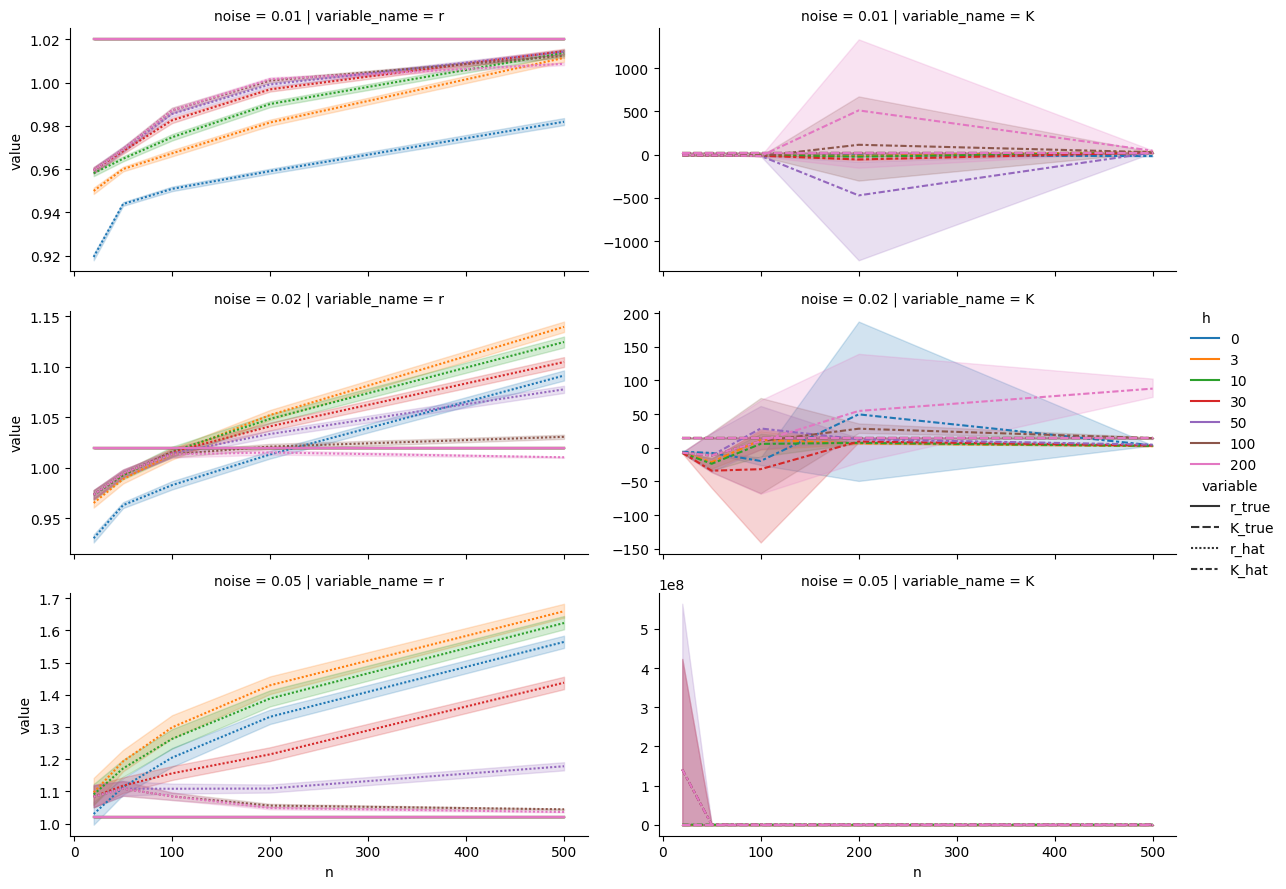

In [105]:
sns.relplot(data=(results_df
                  # .drop(columns=['x0_true', 'r_true', 'K_true', 'r_hat', 'K_hat'])
                  .drop(columns=['x0_true', 'r_error', 'K_error'])
                  .melt(['n', 'h', 'noise'])
                  .assign(variable_name=lambda df: df['variable'].str.split('_', expand=True)[0])), 
            x='n', y='value', 
            style='variable', hue='h',
            col='variable_name', row='noise', palette='tab10',
            facet_kws={'sharey': False}, aspect=2, height=3, kind='line'
           )

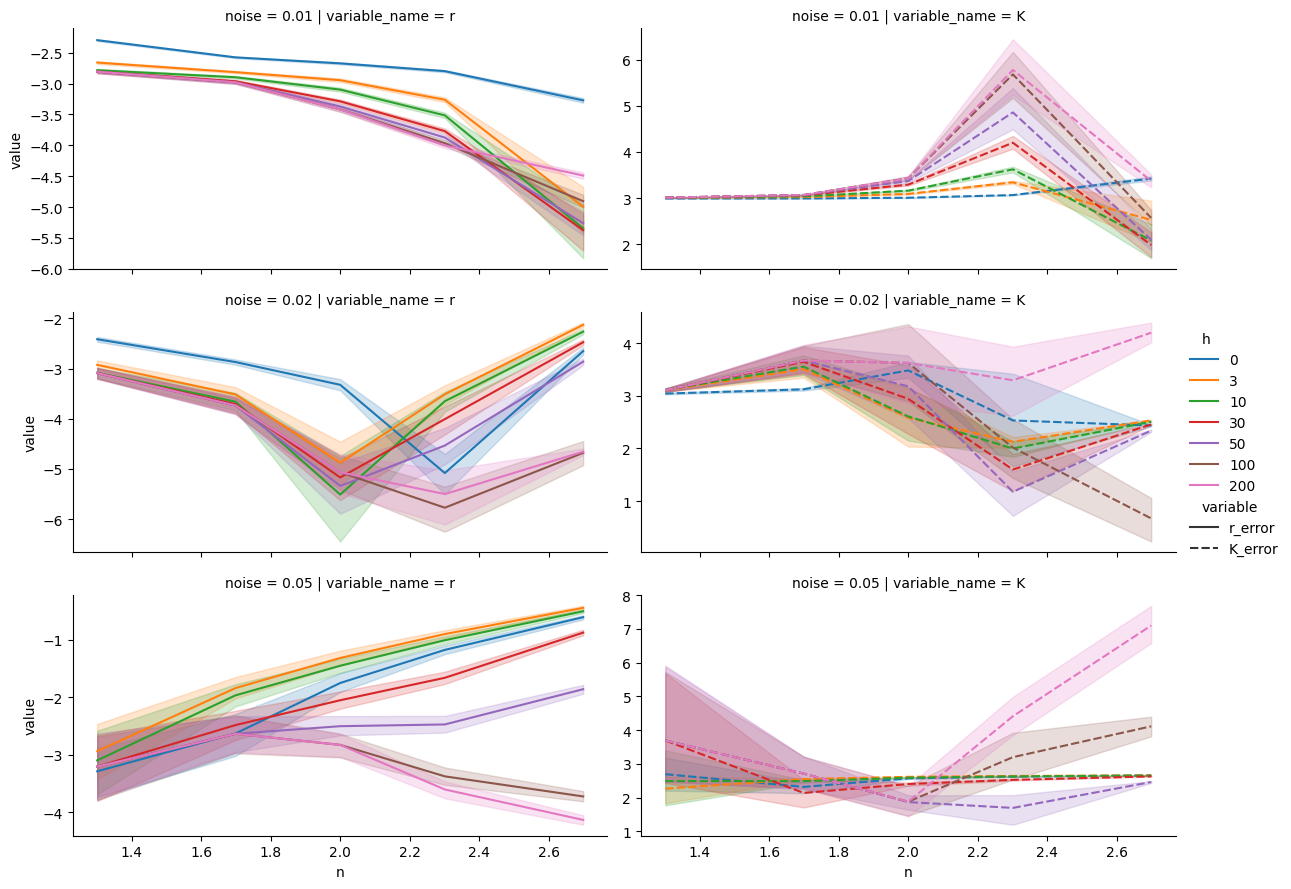

In [106]:
sns.relplot(data=(results_df
                  .drop(columns=['x0_true', 'r_true', 'K_true', 'r_hat', 'K_hat'])
                  # .drop(columns=['x0_true', 'r_error', 'K_error'])
                  .melt(['n', 'h', 'noise'])
                  .assign(variable_name=lambda df: df['variable'].str.split('_', expand=True)[0])
                  .assign(value=lambda x: np.log(x['value']), n=lambda x: np.log10(x['n']))
                 ), 
            x='n', y='value', 
            style='variable', hue='h',
            col='variable_name', row='noise', palette='tab10',
            facet_kws={'sharey': False}, aspect=2, height=3, kind='line',
           )

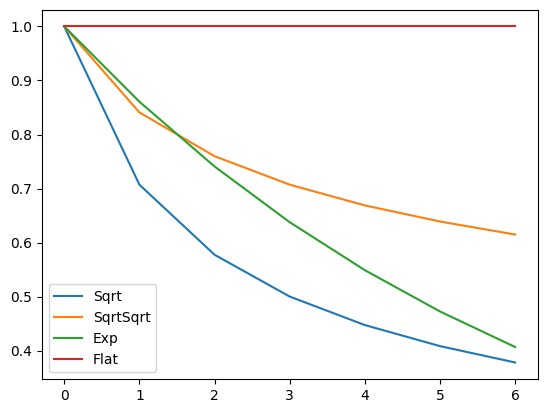

In [256]:
k = 7
plt.plot(1 / np.sqrt(1+np.arange(k)), label="Sqrt")
plt.plot(1 / np.sqrt(np.sqrt(1+np.arange(k))), label="SqrtSqrt")
plt.plot(np.exp(-0.15*np.arange(k)), label="Exp")
plt.plot(np.ones_like(np.arange(k)), label="Flat")
plt.legend()
plt.show()